In [113]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
from pandas.plotting import parallel_coordinates


In [2]:
#load data
# data: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview
articles = pd.read_csv('../../data/articles.csv')
customers = pd.read_csv('../../data/customers.csv')
transactions = pd.read_csv('../../data/transactions_train.csv')

In [3]:
#articles

In [4]:
#customers

In [5]:
#transactions

In [6]:
#group transactions into baskets (customer purchase on date)
baskets = transactions.groupby(['customer_id', 't_dat'])['article_id'].apply(lambda x: ','.join(x.astype(str))).reset_index()

In [7]:
baskets['t_dat'] = pd.to_datetime(baskets['t_dat'])
baskets = baskets.sort_values(by=['t_dat'], ascending=True)

In [8]:
#regular_fashion_news = customers[customers['fashion_news_frequency'] == 'Regularly']
#regular_fashion_news_baskets = baskets[baskets['customer_id'].isin(regular_fashion_news['customer_id'])]

In [9]:
#create list of all baskets
def create_baskets_list (baskets, column_name='article_id'):
        baskets_list = []

        for i in baskets[column_name].values.tolist():
                #only look at baskets with 2 or more items
                if len(i.split(",")) > 1:                       
                        baskets_list.append(i.split(","))
                        
        return baskets_list

In [10]:
#maps article_id to another parameter
def map_baskets(baskets, map):
    mapped_baskets = []
    for basket in baskets:
        basket_list = []
        for item in basket:
            basket_list.append(map[int(item.strip())])
        mapped_baskets.append(basket_list)
    
    return mapped_baskets

In [11]:
baskets_list = create_baskets_list(baskets)

#map of article id and product type
article_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

purchase_list = map_baskets(baskets_list, article_map)

#purchase_list

### Apriori on product types

In [12]:
#applies the apriori algorithm to a dataframe
def apply_apriori(data, min_sup=0.01):
    #preparing the data
    te = TransactionEncoder()
    te_ary = te.fit(data).transform(data)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    #run apriori algorithm
    frequent_tr_encoded = apriori(df, min_support=min_sup, use_colnames=True)

    #cleaning up the data
    frequent_itemsets = frequent_tr_encoded.sort_values(by=['support'], ascending=False)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    return frequent_itemsets

In [13]:
frequent_product_types = apply_apriori(purchase_list)

In [14]:
frequent_product_types[ (frequent_product_types['length'] == 2) ]

,support,itemsets,length
109,0.077951,"(Sweater, Trousers)",2
41,0.072424,"(Bikini top, Swimwear bottom)",2
77,0.060236,"(Dress, Trousers)",2
116,0.057402,"(T-shirt, Trousers)",2
119,0.053178,"(Top, Trousers)",2
...,...,...,...
105,0.010666,"(Socks, Sweater)",2
45,0.010595,"(Blazer, Sweater)",2
120,0.010553,"(Top, Underwear bottom)",2
42,0.010355,"(Bikini top, T-shirt)",2


In [15]:
#applies association rules to frequent itemsets
def apply_association_rules(df, min_thresh=0.4, met='confidence'):
    return association_rules(df, metric=met , min_threshold=min_thresh).sort_values(by=['confidence'], ascending=False)

In [16]:
apply_association_rules(frequent_product_types)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Swimwear bottom),(Bikini top),0.087251,0.087473,0.072424,0.830067,9.489455,0.064792,5.369924
0,(Bikini top),(Swimwear bottom),0.087473,0.087251,0.072424,0.827965,9.489455,0.064792,5.305606
10,"(Swimwear bottom, Dress)",(Bikini top),0.015921,0.087473,0.012747,0.800644,9.153093,0.011355,4.577387
11,"(Bikini top, Dress)",(Swimwear bottom),0.016228,0.087251,0.012747,0.785504,9.002796,0.011331,4.255311
2,(Underwear bottom),(Bra),0.090582,0.112359,0.041088,0.453596,4.037011,0.030910,1.624514
3,(Blazer),(Trousers),0.044468,0.301383,0.020088,0.451746,1.498909,0.006686,1.274258
13,(Jumpsuit/Playsuit),(Dress),0.022973,0.222381,0.010056,0.437743,1.968434,0.004947,1.383031
8,"(Blouse, Sweater)",(Trousers),0.031567,0.301383,0.013565,0.429727,1.425848,0.004051,1.225056
12,"(Blouse, T-shirt)",(Trousers),0.025220,0.301383,0.010690,0.423866,1.406401,0.003089,1.212594
9,"(Blouse, Top)",(Trousers),0.031759,0.301383,0.013087,0.412074,1.367277,0.003515,1.188274


### Seasonal patterns

split transactions into 4 seasons: spring(march-may), summer(june-august), fall(september-november), winter(december-february)

In [17]:
#maps the date time to a season
def map_season(df, column):
    df['month'] = pd.DatetimeIndex(baskets[column]).month

    seasons = []

    for month in df['month']:
        if (month >= 3) and (month < 6):
            seasons.append('spring')
        elif (month >= 6) and (month < 9):
            seasons.append('summer')
        elif (month >= 9) and (month < 12):
            seasons.append('fall')
        else:
            seasons.append('winter')
    
    df['season'] = seasons

In [18]:
map_season(baskets, 't_dat')

In [19]:
baskets

,customer_id,t_dat,article_id,month,season
971624,1b4ad1bb792824540e946a0b0753732b12a4e093838130...,2018-09-20,561222001,9,fall
5811242,a3a4bef27deb7e281bba5e69ec1e4ada1b92d0830f71b3...,2018-09-20,"539723005,539723007",9,fall
5901446,a63a9c42f9842cf133395720e7b8ab036ac17e90315e8f...,2018-09-20,"564787001,523489001,436083003,241412038,637661...",9,fall
6871699,c1a248efd4e623a732edd6a82c1b86f8855e39366f1b37...,2018-09-20,"551989032,394522001,670655001,670655001,627389...",9,fall
3345344,5e718141459ee81cd3197c22a9486c8d85b2ac25ea5f6c...,2018-09-20,"652708001,680810002,655855001,652671001,652696001",9,fall
...,...,...,...,...,...
900159,194200ea696f8e82e325c94736ba64067cd75a039589af...,2020-09-22,399256001,9,fall
4786982,871bce4bca27facb372fde060289617b935303d5636e21...,2020-09-22,"889036004,895028001,786022008,850917001",9,fall
6341001,b2b1ca97a7561c08682032a8b6a0d0f2c76be0682c1105...,2020-09-22,"843597002,843597002",9,fall
3201045,5a5972b26f99c8fefd7dc1a9ac9c2b899b75eed22d2226...,2020-09-22,"893197001,876926001,862272004",9,fall


In [20]:
spring_baskets = baskets[baskets['season'] == 'spring']
summer_baskets = baskets[baskets['season'] == 'summer']
fall_baskets = baskets[baskets['season'] == 'fall']
winter_baskets = baskets[baskets['season'] == 'winter']

#### Spring

In [21]:
spring_baskets_list = create_baskets_list(spring_baskets)

#map of article id and product type
spring_article_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

spring_purchase_list = map_baskets(spring_baskets_list, spring_article_map)

In [22]:
spring_frequent_product_types = apply_apriori(spring_purchase_list)

spring_frequent_product_types[ (spring_frequent_product_types['length'] == 2) ]

,support,itemsets,length
39,0.112103,"(Swimwear bottom, Bikini top)",2
119,0.075016,"(T-shirt, Trousers)",2
79,0.075010,"(Dress, Trousers)",2
122,0.059783,"(Top, Trousers)",2
55,0.055514,"(Blouse, Trousers)",2
...,...,...,...
107,0.010524,"(Socks, T-shirt)",2
67,0.010496,"(Cardigan, Trousers)",2
37,0.010462,"(Skirt, Bikini top)",2
75,0.010362,"(Swimsuit, Dress)",2


In [23]:
apply_association_rules(spring_frequent_product_types, 0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,"(Swimsuit, Swimwear bottom)",(Bikini top),0.012809,0.133066,0.011453,0.894177,6.719810,0.009749,8.192322
0,(Swimwear bottom),(Bikini top),0.130018,0.133066,0.112103,0.862207,6.479553,0.094802,6.291575
13,"(Swimsuit, Bikini top)",(Swimwear bottom),0.013319,0.130018,0.011453,0.859892,6.613620,0.009721,6.209363
16,"(Swimwear bottom, Bra)",(Bikini top),0.012433,0.133066,0.010680,0.858996,6.455417,0.009025,6.148275
2,"(Swimwear bottom, Dress)",(Bikini top),0.025151,0.133066,0.021207,0.843179,6.336557,0.017860,5.528188
1,(Bikini top),(Swimwear bottom),0.133066,0.130018,0.112103,0.842461,6.479553,0.094802,5.522316
6,"(Swimwear bottom, Vest top)",(Bikini top),0.017068,0.133066,0.014336,0.839964,6.312393,0.012065,5.417115
14,"(Swimwear bottom, Top)",(Bikini top),0.013254,0.133066,0.011129,0.839674,6.310217,0.009366,5.407331
4,"(Swimwear bottom, Trousers)",(Bikini top),0.020542,0.133066,0.016798,0.817718,6.145217,0.014064,4.756017
11,"(Bikini top, Shorts)",(Swimwear bottom),0.016807,0.130018,0.013716,0.816083,6.276677,0.011531,4.730299


#### Summer

In [24]:
summer_baskets_list = create_baskets_list(summer_baskets)

#map of article id and product type
summer_article_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

summer_purchase_list = map_baskets(summer_baskets_list, summer_article_map)

In [25]:
summer_frequent_product_types = apply_apriori(summer_purchase_list)

summer_frequent_product_types[ (summer_frequent_product_types['length'] == 2) ]

,support,itemsets,length
40,0.113673,"(Bikini top, Swimwear bottom)",2
75,0.064673,"(Dress, Trousers)",2
113,0.058385,"(T-shirt, Trousers)",2
73,0.050136,"(Dress, T-shirt)",2
47,0.049236,"(Dress, Blouse)",2
...,...,...,...
58,0.010502,"(Leggings/Tights, Bra)",2
52,0.010482,"(Swimwear bottom, Blouse)",2
35,0.010400,"(Bikini top, Blouse)",2
80,0.010351,"(Jumpsuit/Playsuit, Trousers)",2


In [26]:
apply_association_rules(summer_frequent_product_types, 0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bikini top),(Swimwear bottom),0.138534,0.139896,0.113673,0.820543,5.865368,0.094293,4.792816
1,(Swimwear bottom),(Bikini top),0.139896,0.138534,0.113673,0.812551,5.865368,0.094293,4.595741
4,"(Bikini top, Shorts)",(Swimwear bottom),0.019821,0.139896,0.015518,0.782907,5.596339,0.012745,3.961914
2,"(Bikini top, Dress)",(Swimwear bottom),0.024880,0.139896,0.019223,0.772649,5.523013,0.015743,3.783154
3,"(Swimwear bottom, Dress)",(Bikini top),0.024921,0.138534,0.019223,0.771354,5.567990,0.015771,3.767691
6,"(Bikini top, Vest top)",(Swimwear bottom),0.018439,0.139896,0.014155,0.767661,5.487355,0.011576,3.701929
7,"(Swimwear bottom, Vest top)",(Bikini top),0.018503,0.138534,0.014155,0.765017,5.522247,0.011592,3.666085
10,"(Bikini top, Trousers)",(Swimwear bottom),0.014829,0.139896,0.011269,0.759938,5.432152,0.009194,3.582838
8,"(Bikini top, T-shirt)",(Swimwear bottom),0.014934,0.139896,0.011332,0.758828,5.424221,0.009243,3.566355
11,"(Swimwear bottom, Trousers)",(Bikini top),0.015494,0.138534,0.011269,0.727323,5.250151,0.009122,3.159292


#### Fall

In [27]:
fall_baskets_list = create_baskets_list(fall_baskets)

#map of article id and product type
fall_article_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

fall_purchase_list = map_baskets(fall_baskets_list, fall_article_map)

In [28]:
fall_frequent_product_types = apply_apriori(fall_purchase_list)

fall_frequent_product_types[ (fall_frequent_product_types['length'] == 2) ]

,support,itemsets,length
97,0.137626,"(Sweater, Trousers)",2
96,0.069318,"(Sweater, Top)",2
67,0.057055,"(Dress, Sweater)",2
103,0.055151,"(Top, Trousers)",2
95,0.054722,"(T-shirt, Sweater)",2
...,...,...,...
36,0.010944,"(Blazer, Blouse)",2
49,0.010773,"(Boots, Trousers)",2
47,0.010766,"(Blouse, Vest top)",2
57,0.010744,"(Vest top, Bra)",2


In [29]:
apply_association_rules(fall_frequent_product_types, 0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(Bikini top),(Swimwear bottom),0.016147,0.016760,0.012380,0.766689,45.745147,0.012109,4.214290
6,(Swimwear bottom),(Bikini top),0.016760,0.016147,0.012380,0.738638,45.745147,0.012109,3.764327
4,"(Cardigan, Trousers)",(Sweater),0.022690,0.391871,0.012726,0.560850,1.431209,0.003834,1.384785
3,"(Skirt, Trousers)",(Sweater),0.023792,0.391871,0.013039,0.548039,1.398518,0.003715,1.345533
2,"(Trousers, Hoodie)",(Sweater),0.028048,0.391871,0.014837,0.528988,1.349903,0.003846,1.291111
0,(Cardigan),(Sweater),0.064066,0.391871,0.032543,0.507955,1.296229,0.007437,1.235921
1,"(Top, Trousers)",(Sweater),0.055151,0.391871,0.027592,0.500295,1.276682,0.005980,1.216975


#### Winter

In [30]:
winter_baskets_list = create_baskets_list(winter_baskets)

#map of article id and product type
winter_article_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

winter_purchase_list = map_baskets(winter_baskets_list, winter_article_map)

In [31]:
winter_frequent_product_types = apply_apriori(winter_purchase_list)

winter_frequent_product_types[ (winter_frequent_product_types['length'] == 2) ]

,support,itemsets,length
94,0.108333,"(Sweater, Trousers)",2
93,0.054581,"(Sweater, Top)",2
101,0.051364,"(Top, Trousers)",2
68,0.049565,"(Dress, Trousers)",2
57,0.048917,"(Bra, Underwear bottom)",2
...,...,...,...
42,0.011300,"(Blouse, Bra)",2
39,0.010697,"(Blazer, Blouse)",2
102,0.010555,"(Top, Underwear bottom)",2
91,0.010548,"(Socks, Underwear bottom)",2


In [32]:
apply_association_rules(winter_frequent_product_types, 0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Swimwear bottom),(Bikini top),0.048447,0.048575,0.040554,0.837081,17.232756,0.038201,5.839867
0,(Bikini top),(Swimwear bottom),0.048575,0.048447,0.040554,0.834877,17.232756,0.038201,5.762709


### Monthly Itemsets

In [131]:
m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthly_baskets = []

for n in months:
    monthly_baskets.append(baskets[baskets['month'] == n])


In [116]:
monthly_purchases = []
monthly_article_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

for basket in monthly_baskets:
    monthly_purchases.append(map_baskets(create_baskets_list(basket), monthly_article_map))

In [121]:
monthly_supports = {}
monthly_rules = {}

for key, value in zip(m, monthly_purchases):
    apr = apply_apriori(value)
    monthly_supports[key] = apr
    monthly_rules[key] = apply_association_rules(apr, 0.45)

In [122]:
monthly_rules['dec']

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(Bikini top),(Swimwear bottom),0.017575,0.017675,0.013816,0.786092,44.475849,0.013505,4.592277
4,(Swimwear bottom),(Bikini top),0.017675,0.017575,0.013816,0.781684,44.475849,0.013505,4.500019
6,"(Hoodie, Trousers)",(Sweater),0.020617,0.355381,0.010261,0.497697,1.400461,0.002934,1.283327
2,(Cardigan),(Sweater),0.040975,0.355381,0.020247,0.494130,1.390425,0.005685,1.274279
5,"(Skirt, Trousers)",(Sweater),0.022832,0.355381,0.011254,0.492902,1.386968,0.003140,1.271192
0,(Underwear bottom),(Bra),0.097548,0.117006,0.047193,0.483799,4.134816,0.035780,1.710561
1,(Hoodie),(Sweater),0.058536,0.355381,0.026614,0.454661,1.279363,0.005811,1.182052
7,"(T-shirt, Top)",(Sweater),0.022260,0.355381,0.010081,0.452884,1.274364,0.002170,1.178214


In [123]:
# Convert antecedents and consequents into strings
for month in m:
    monthly_rules[month]['ant'] = monthly_rules[month]['antecedents'].apply(lambda a: ','.join(list(a)))
    monthly_rules[month]['con'] = monthly_rules[month]['consequents'].apply(lambda a: ','.join(list(a)))

### Heatmap of support

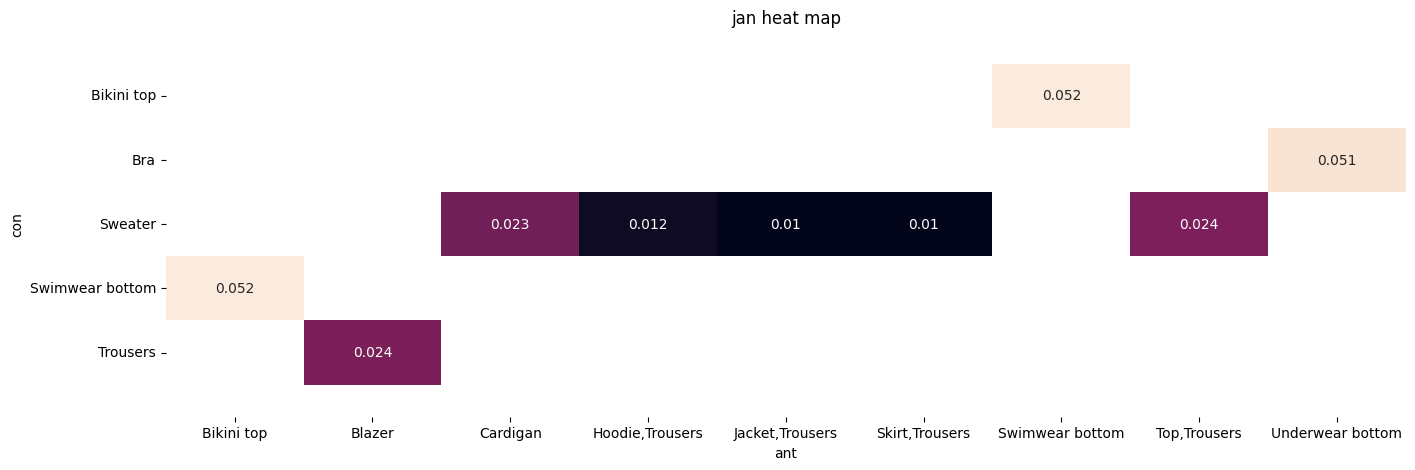

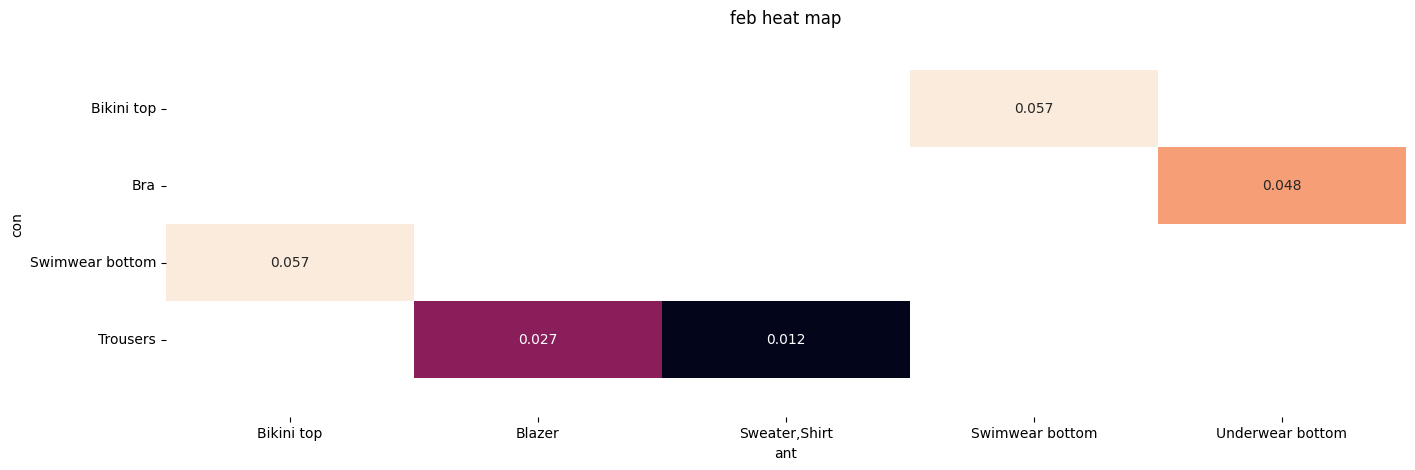

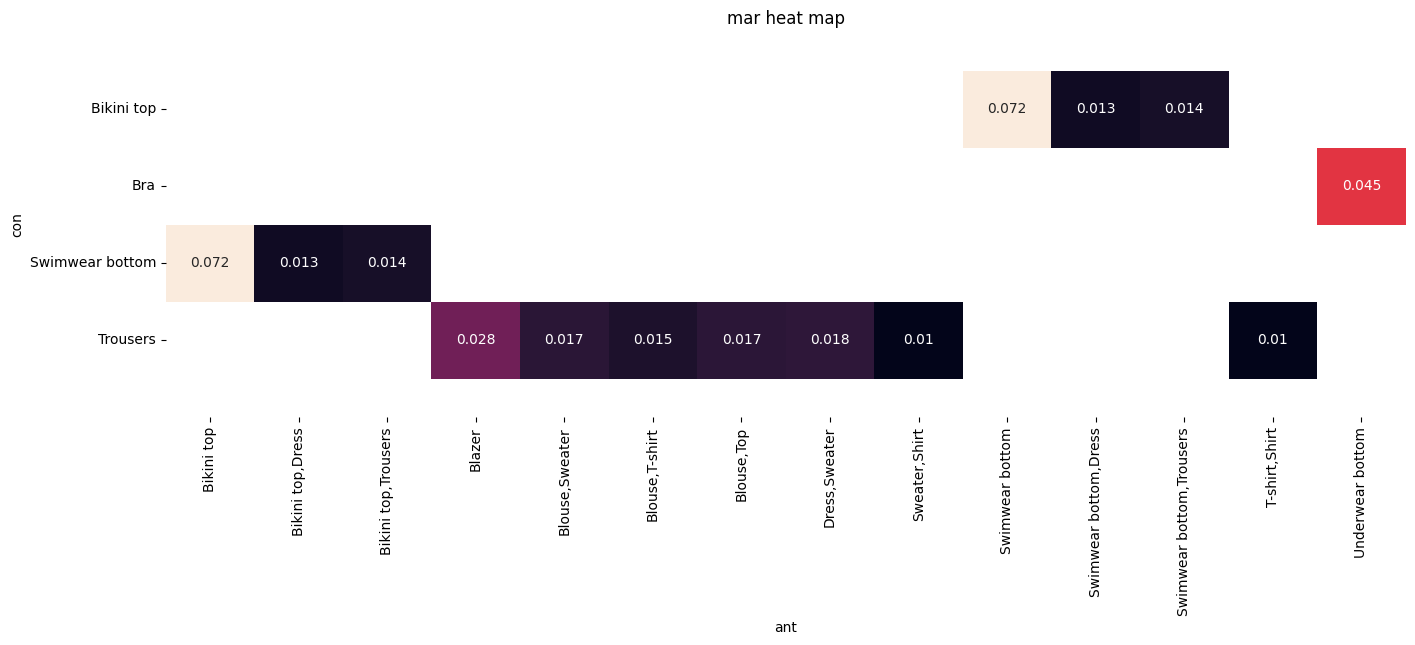

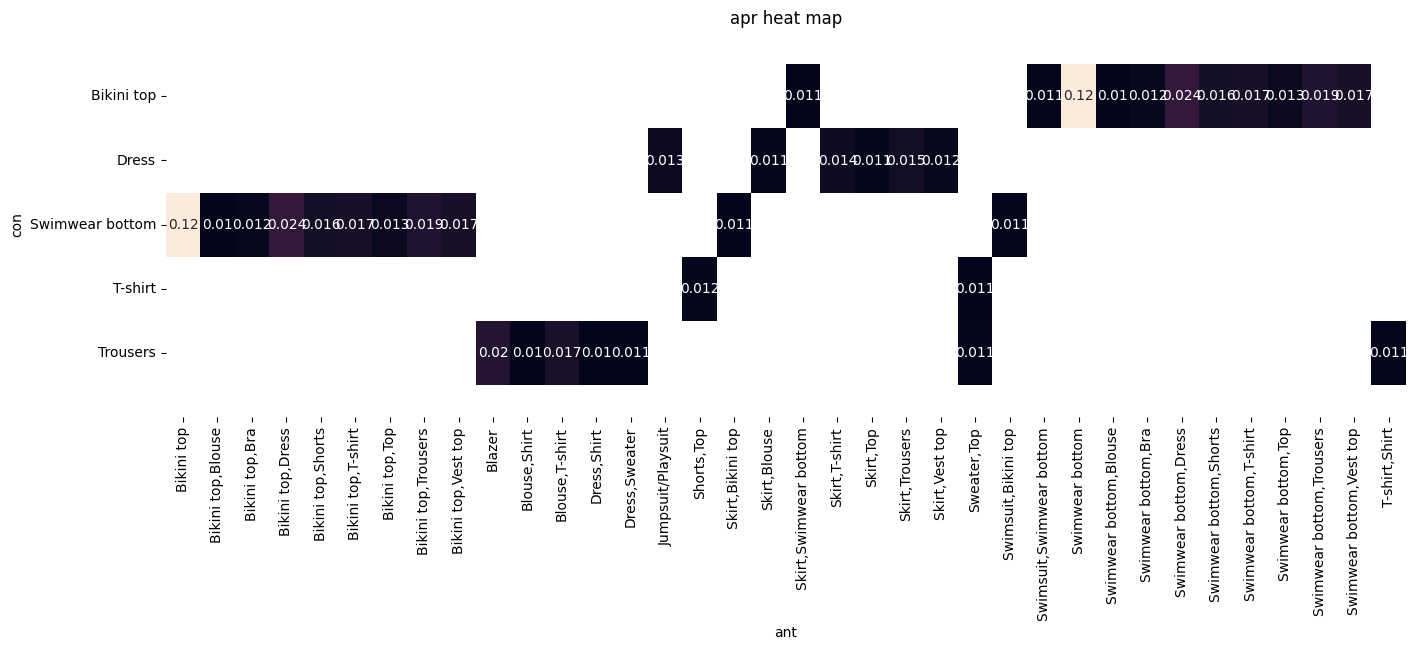

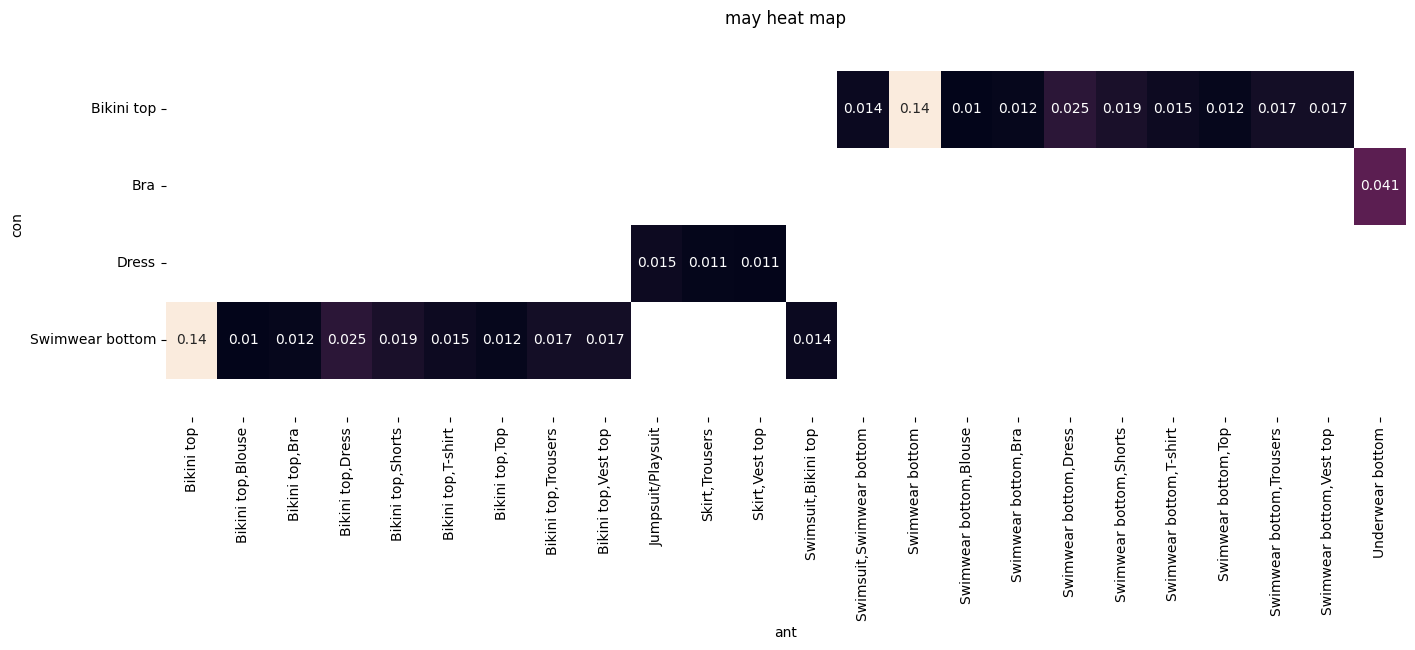

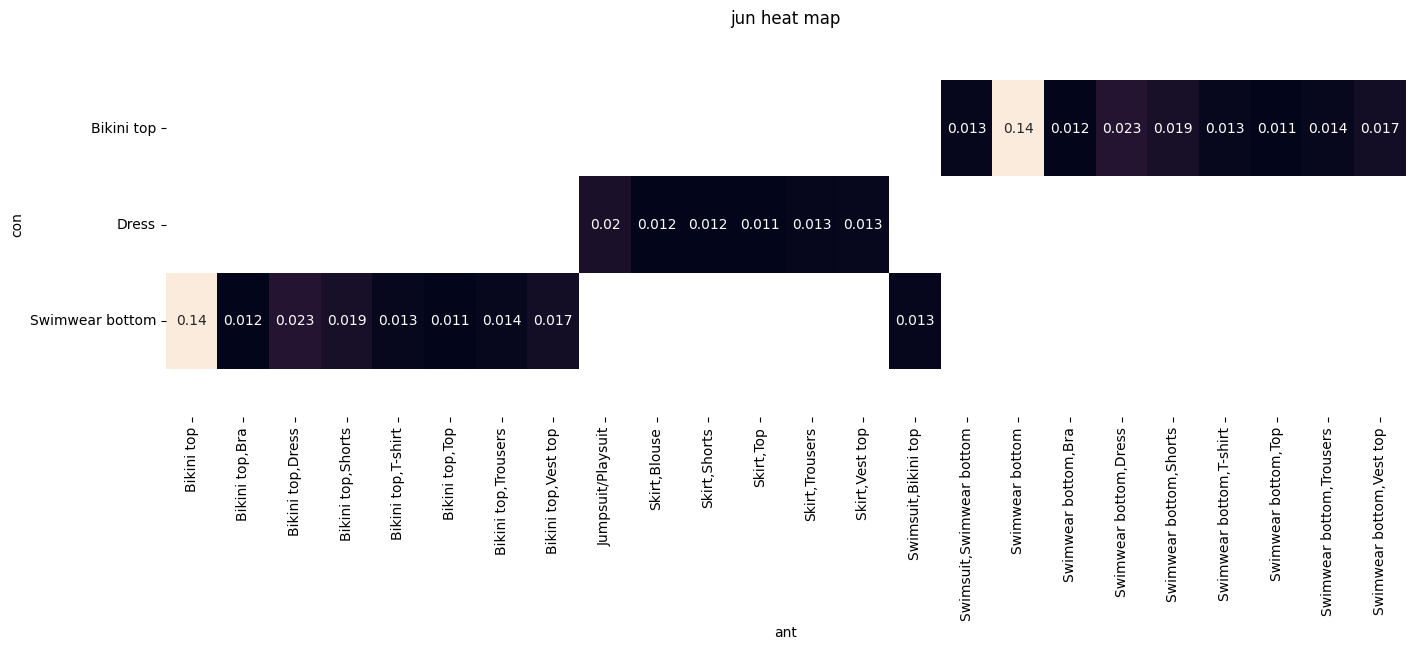

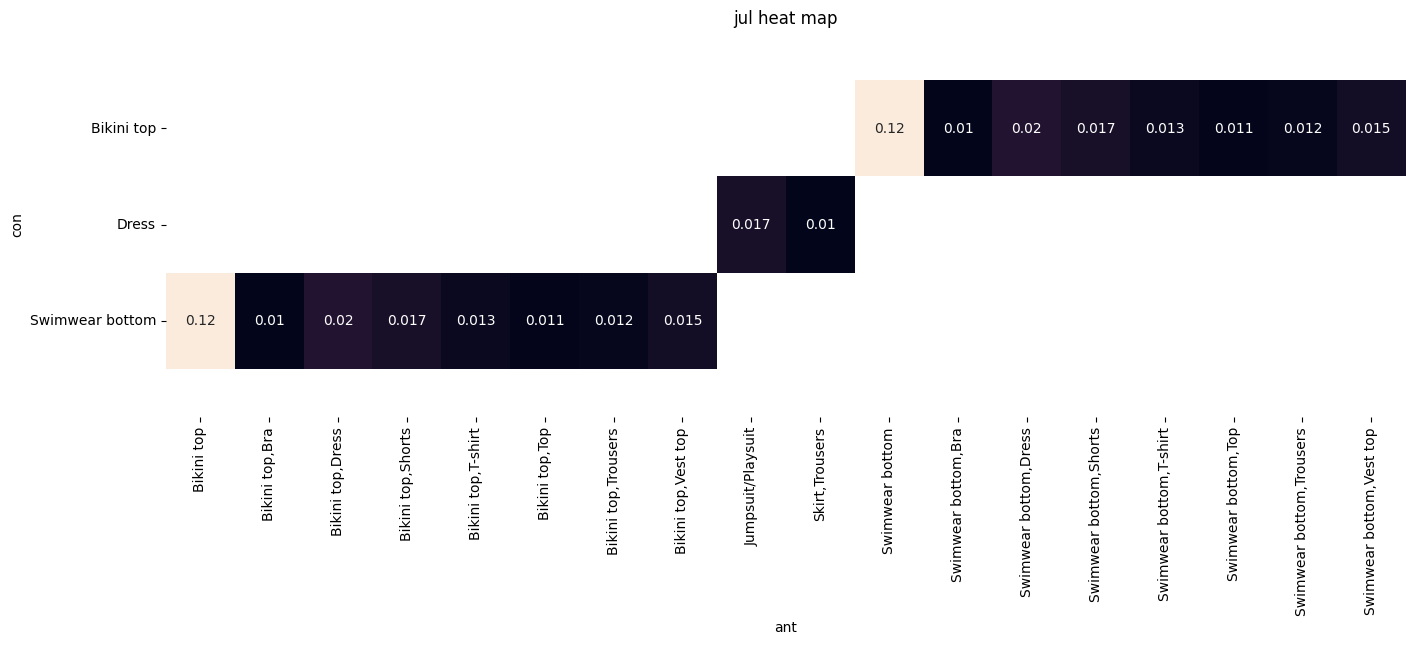

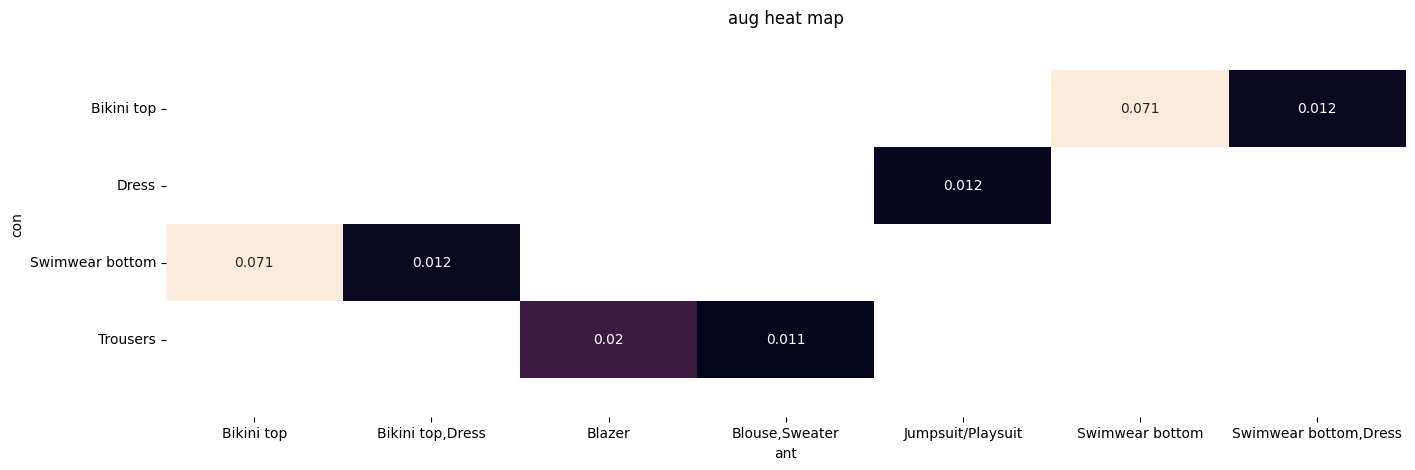

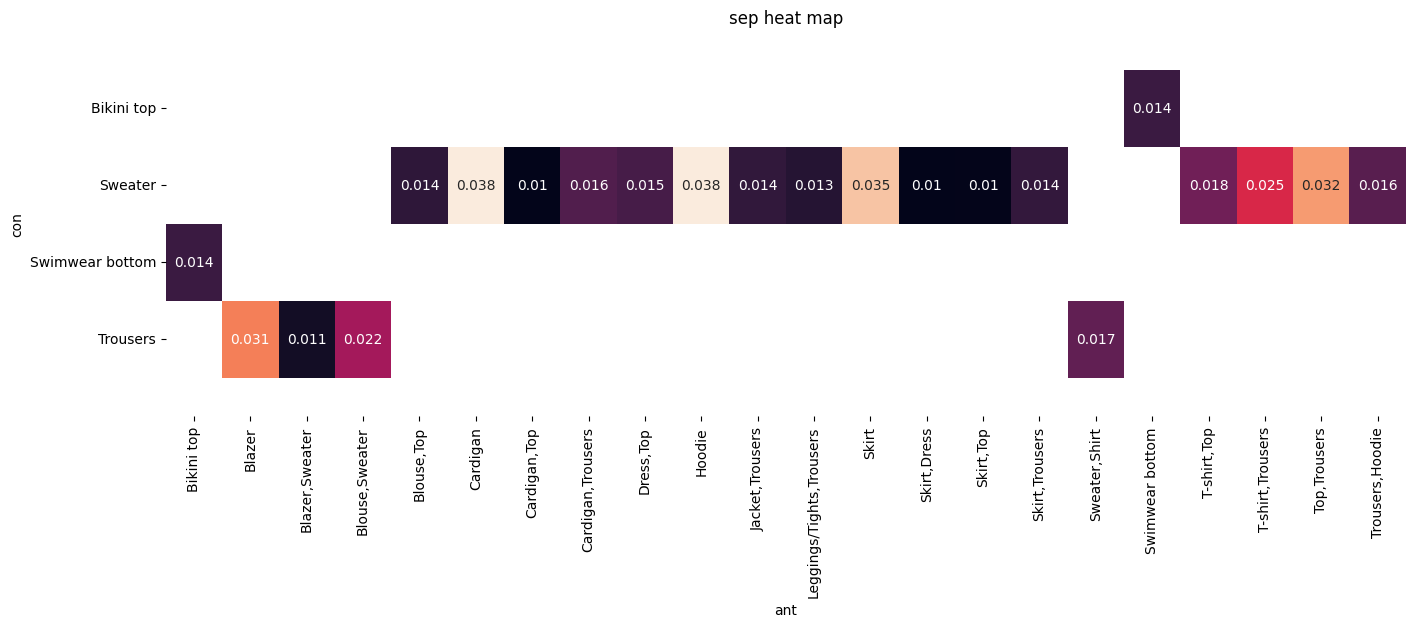

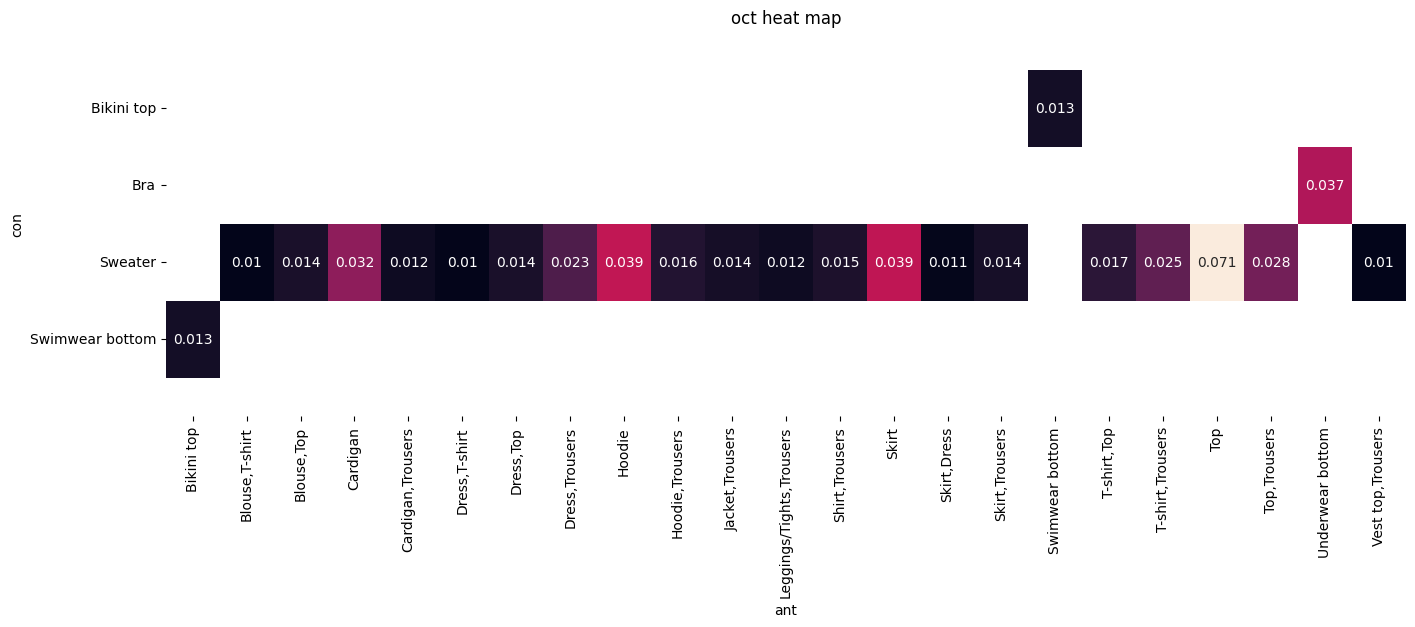

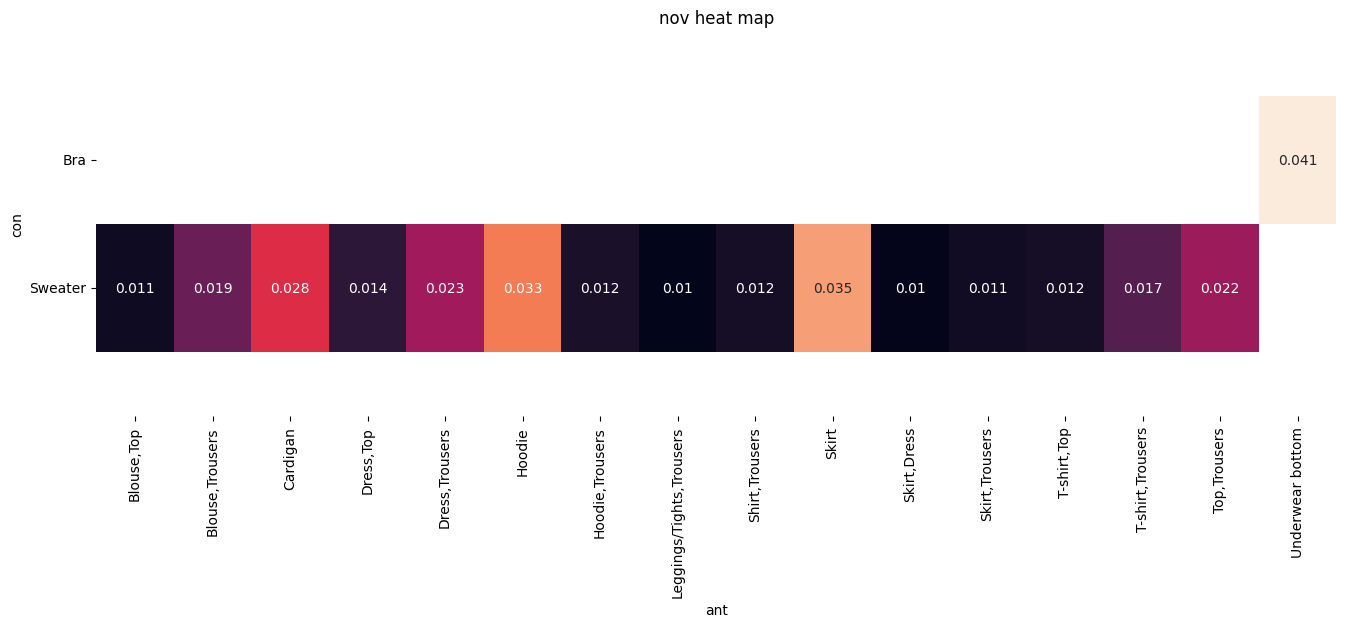

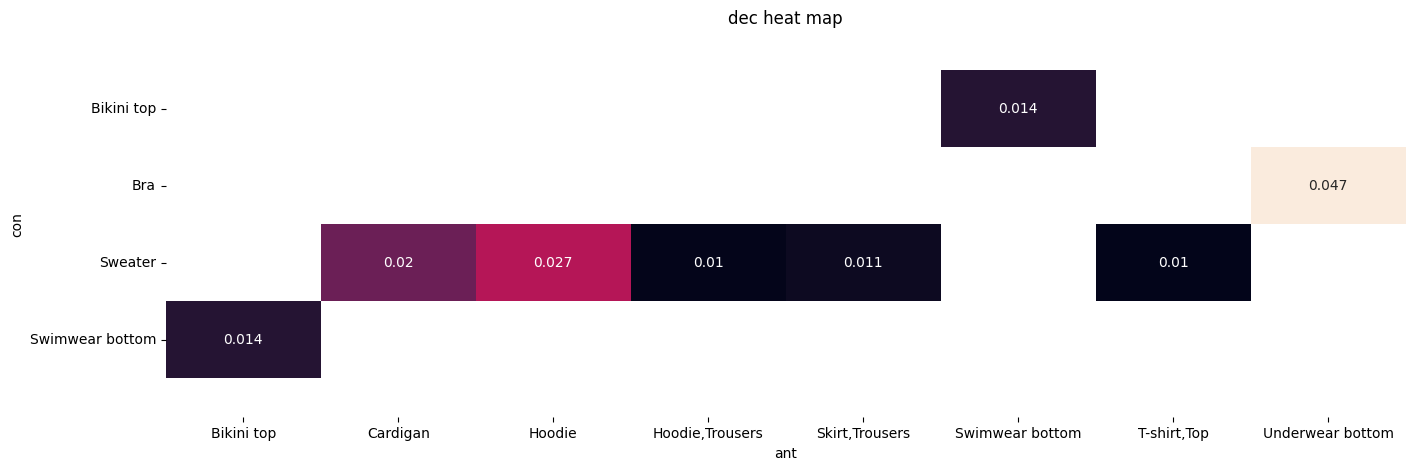

In [124]:
for month in m:
    support_table = monthly_rules[month].pivot(index='con', columns='ant', values='support')
    plt.figure(figsize=(16,5))
    sns.heatmap(support_table, annot=True, cbar=False)
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.yticks(rotation=0)
    plt.title(month + ' heat map')
    plt.show() 

### monthly heatmaps with Lift

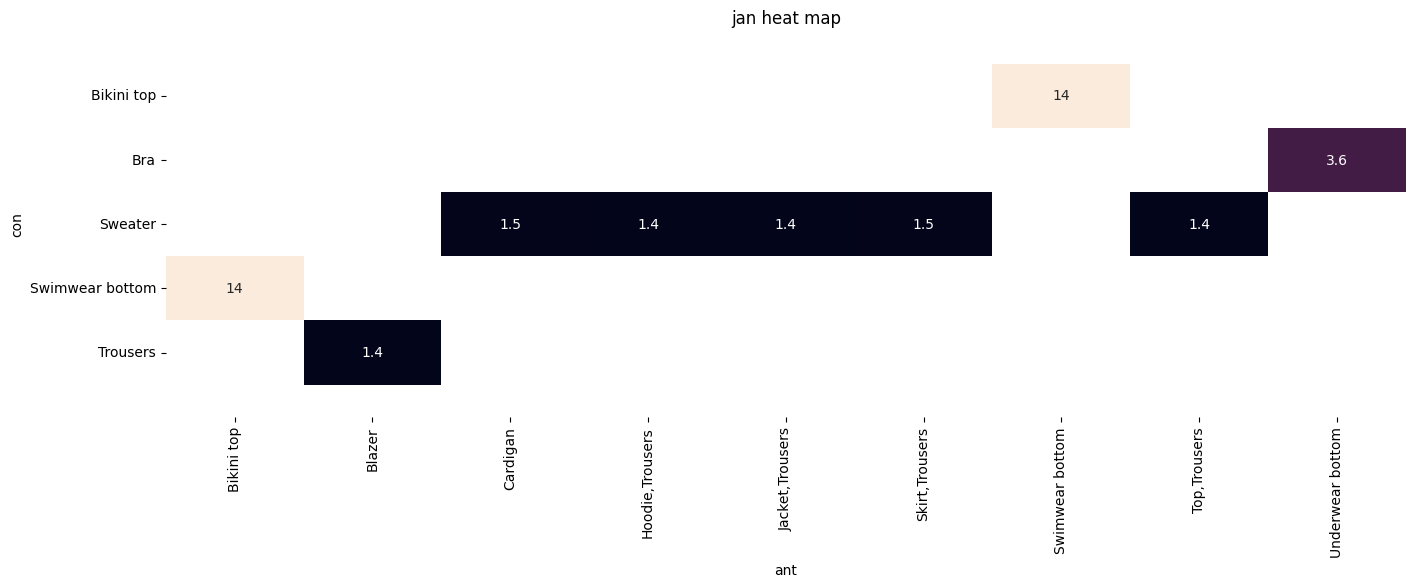

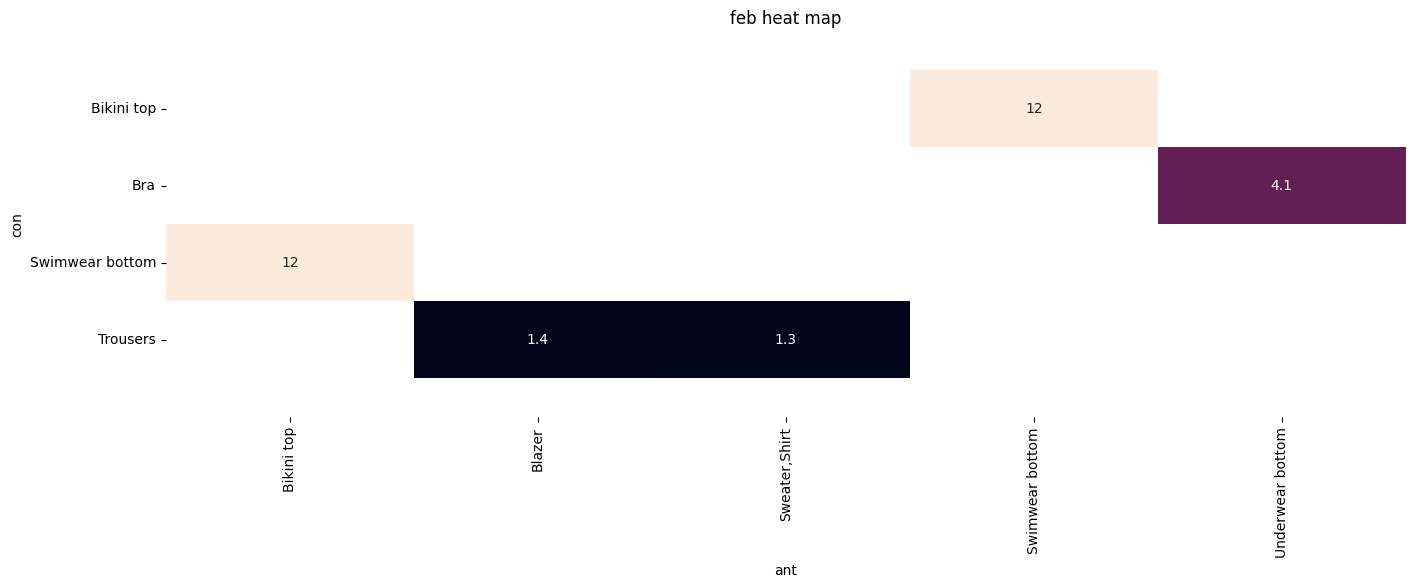

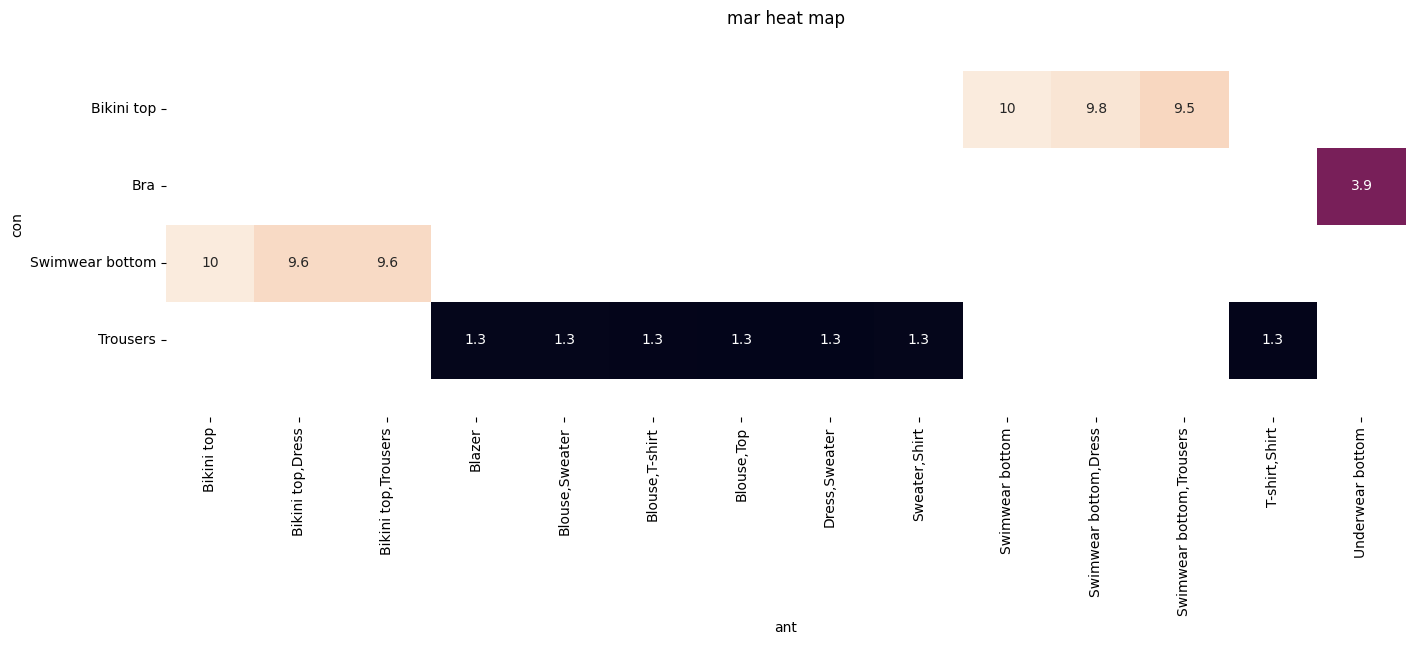

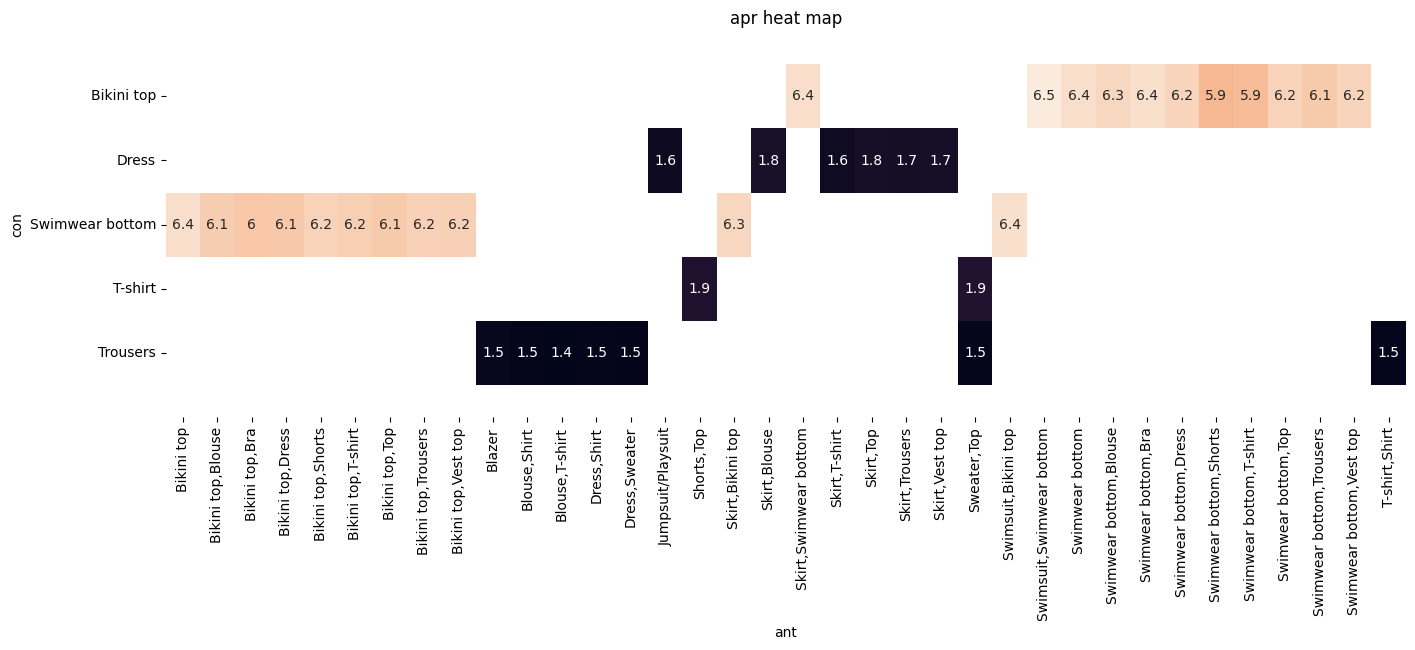

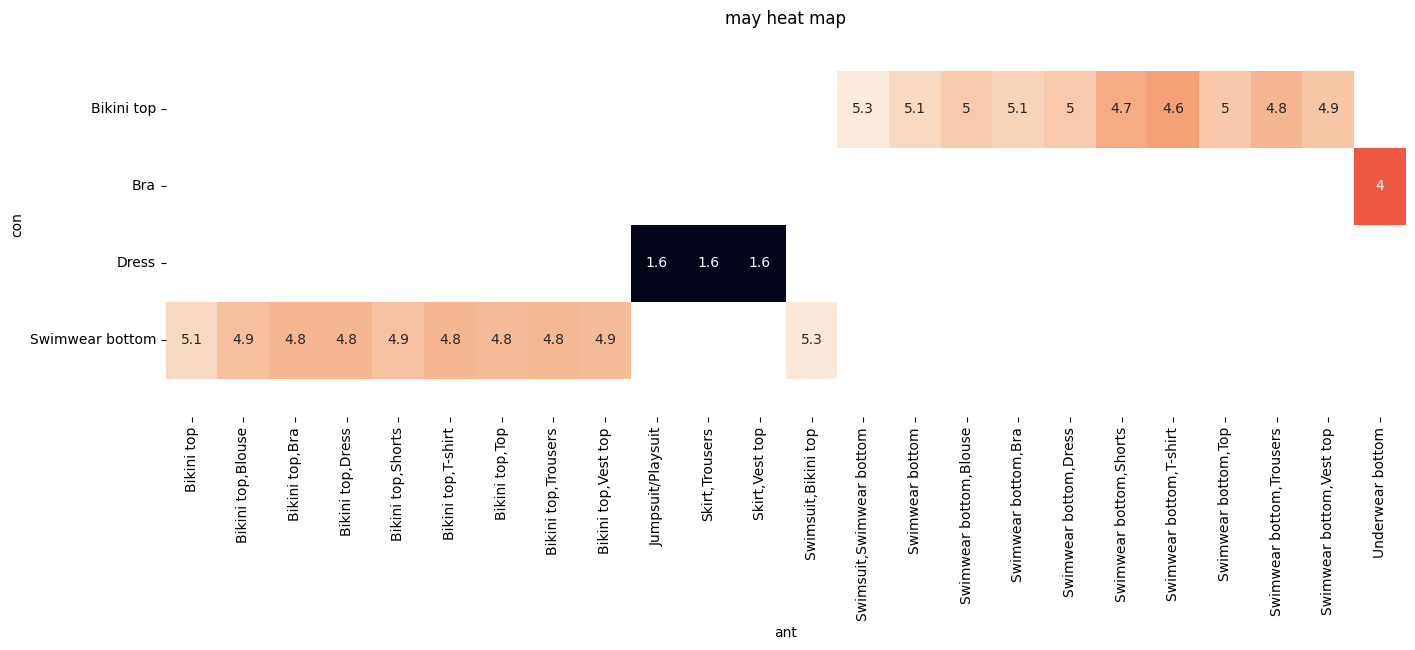

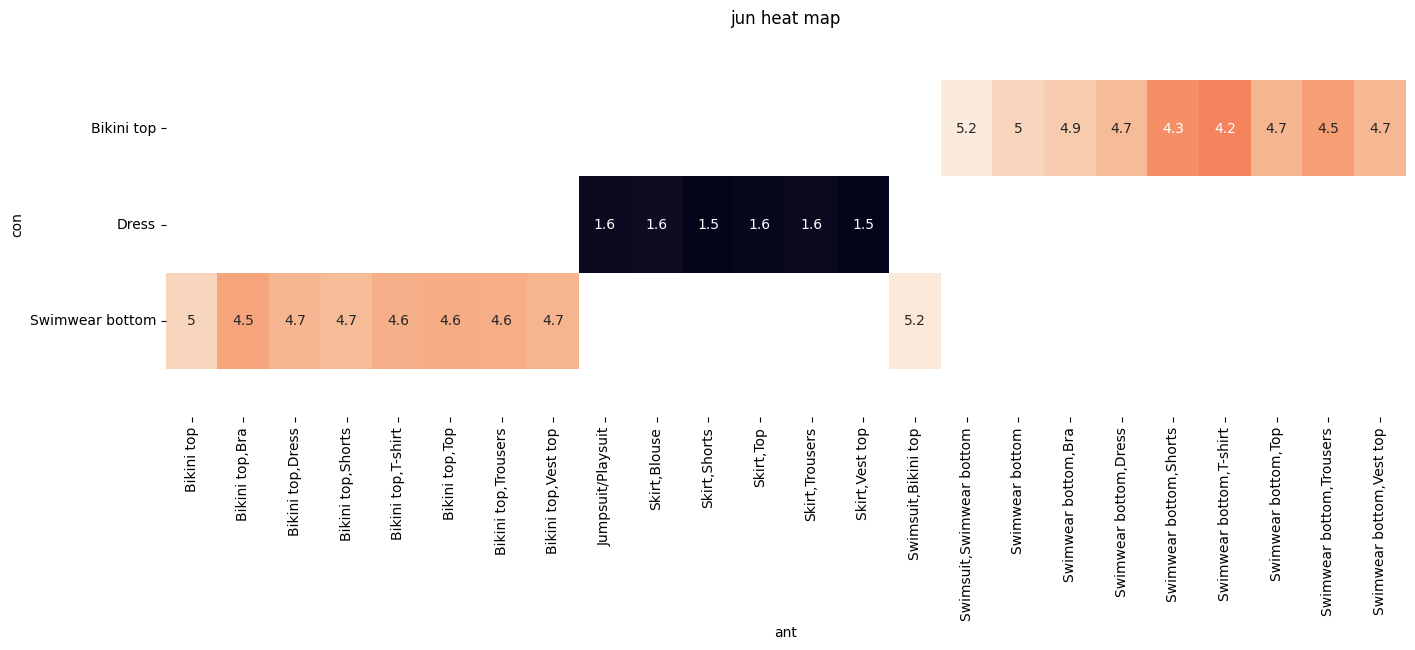

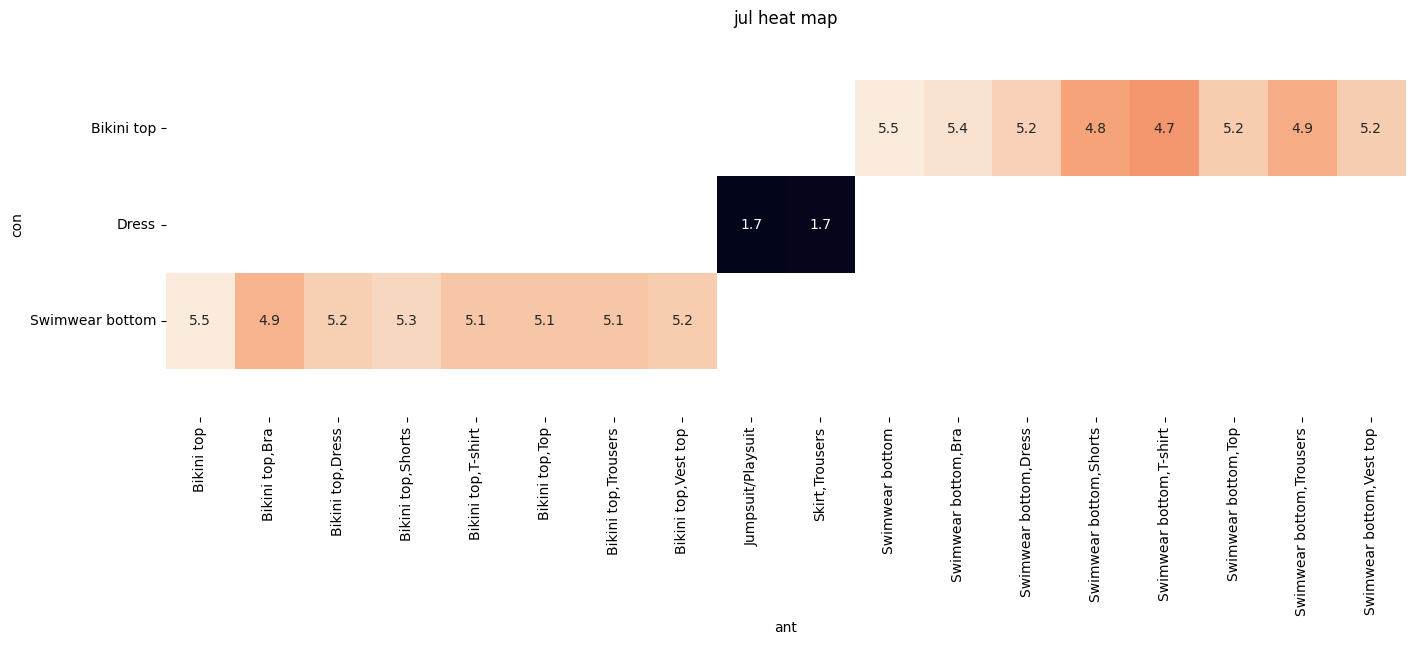

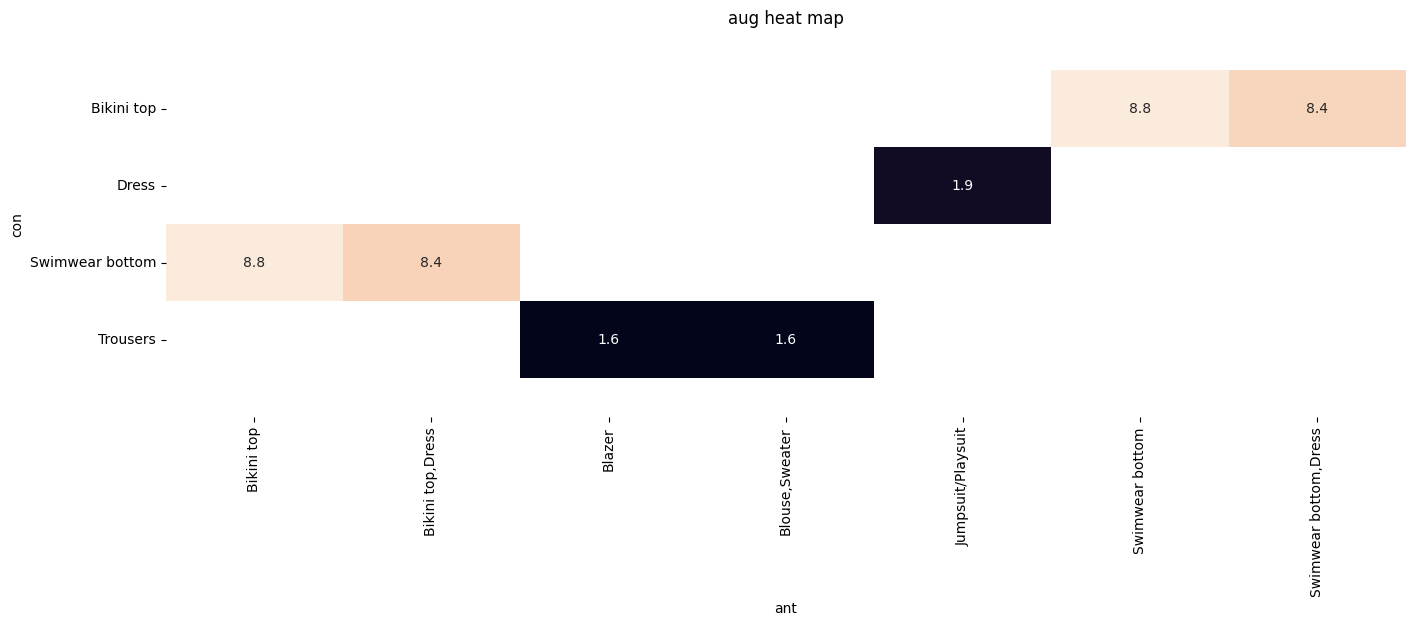

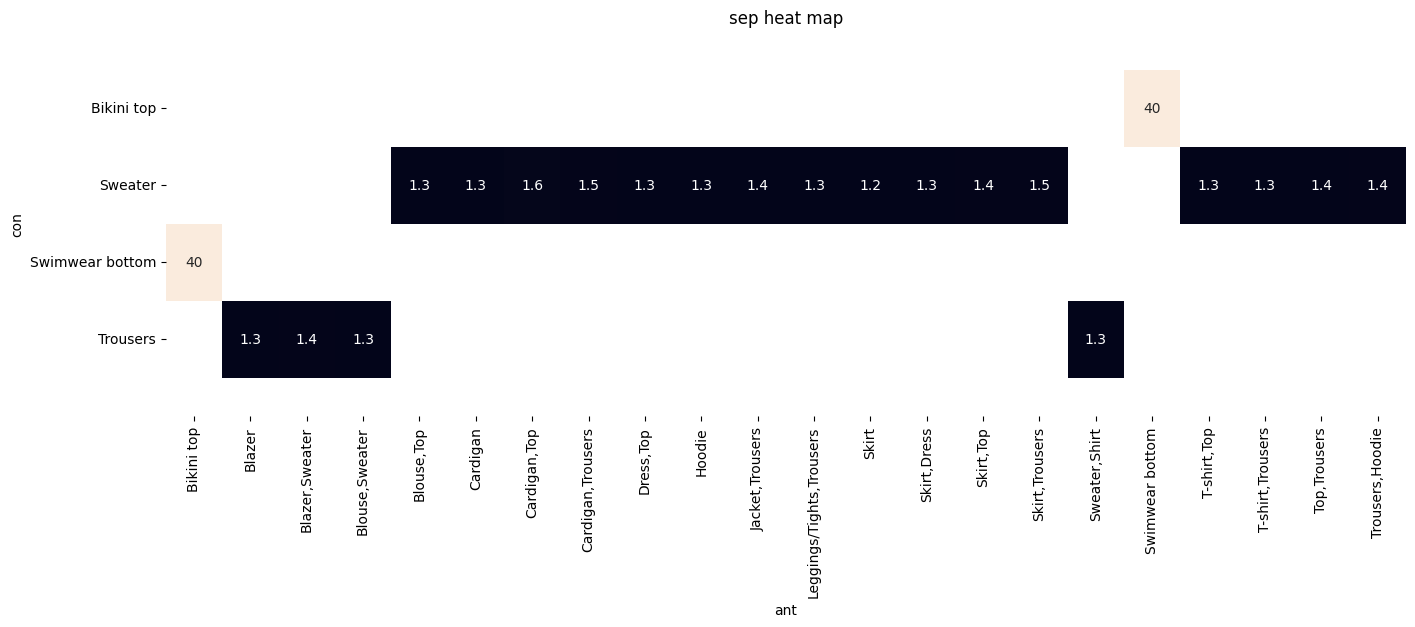

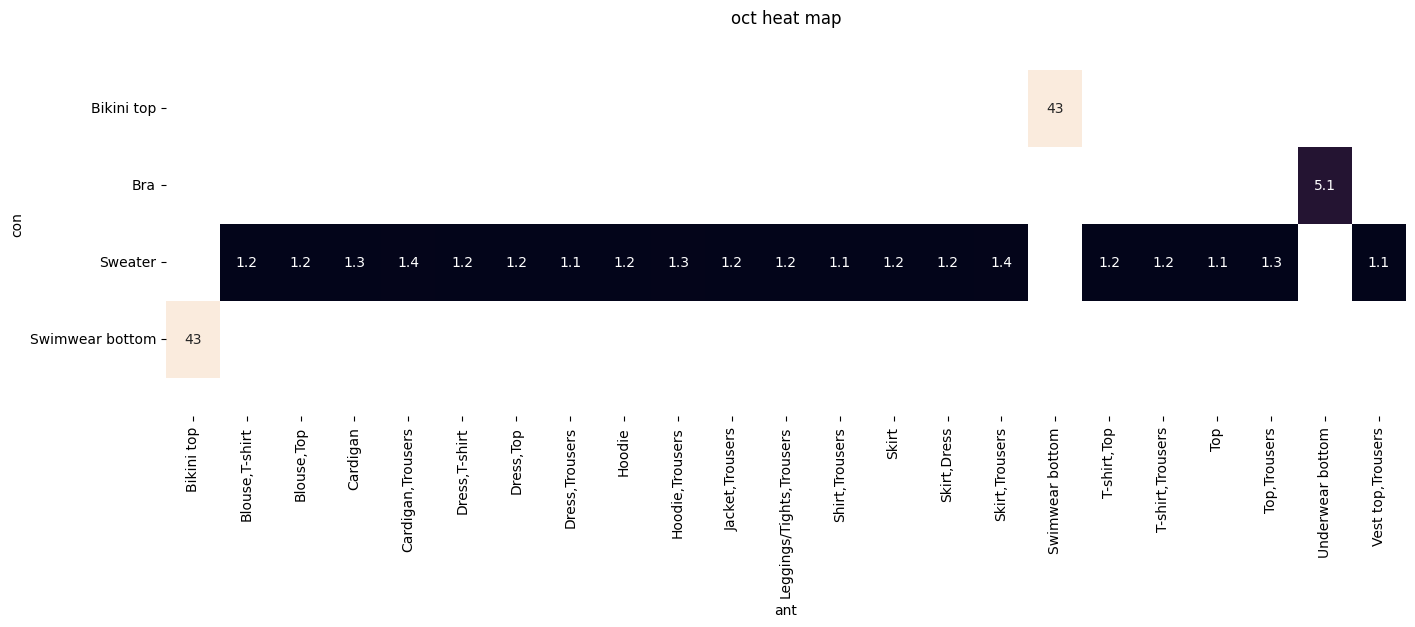

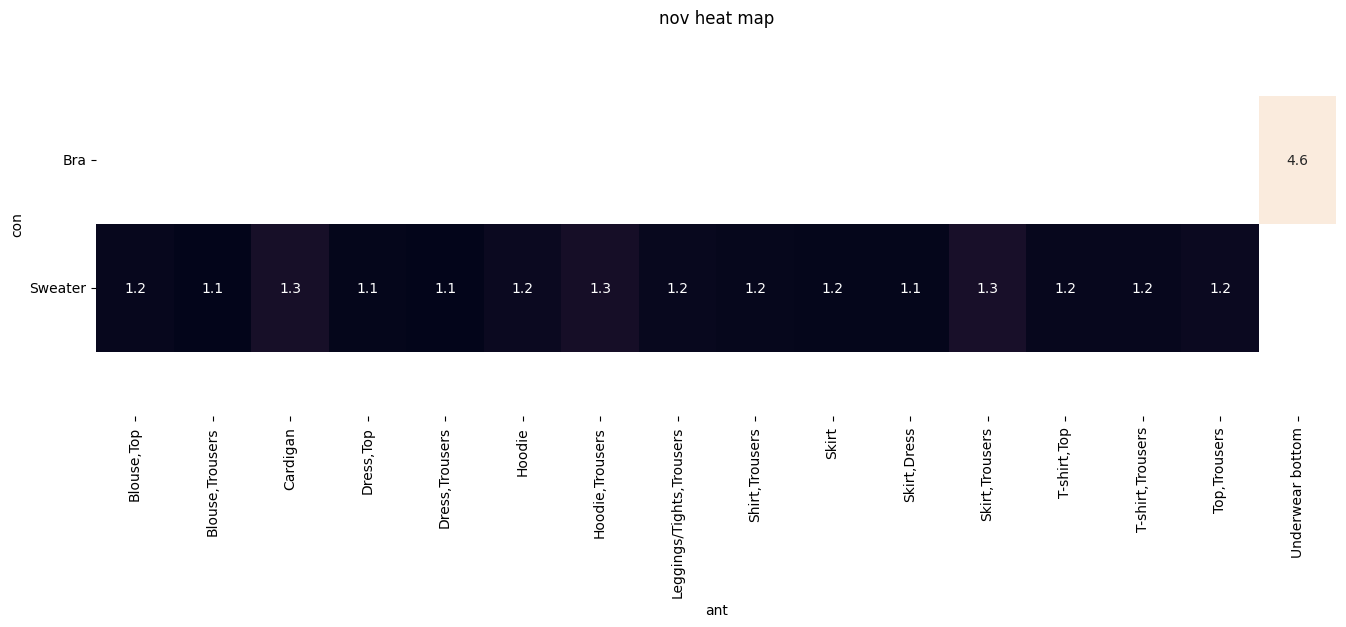

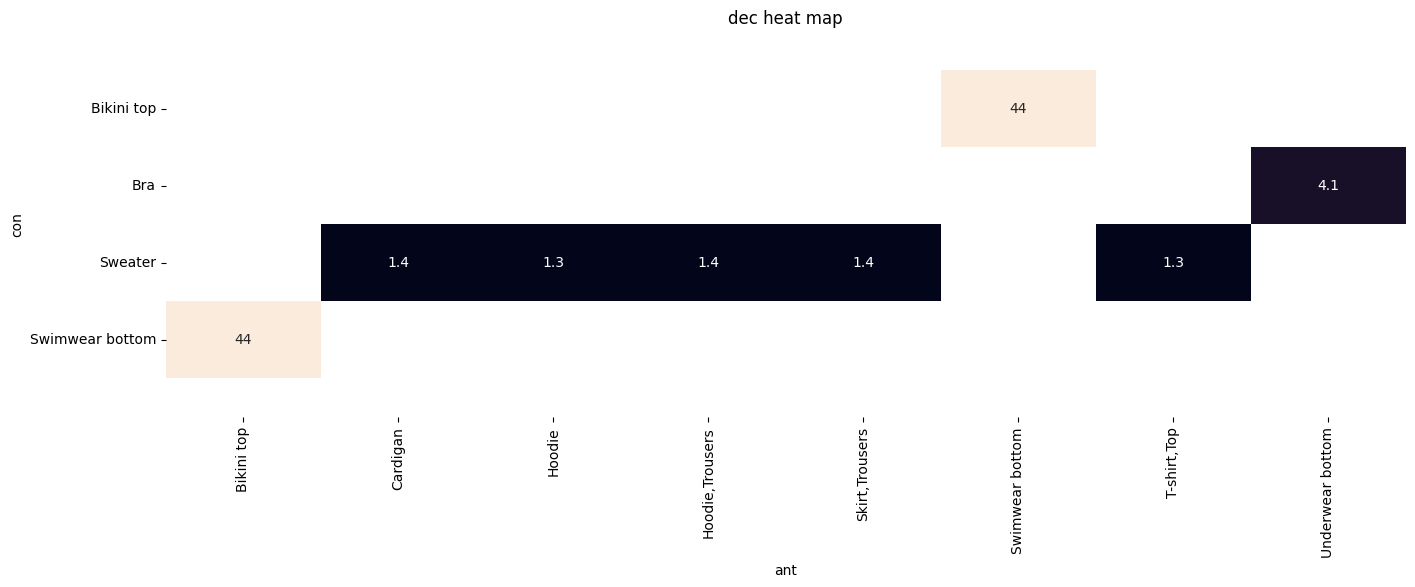

In [125]:
for month in m:
    pivot = monthly_rules[month].pivot(index = 'con', columns = 'ant', values= 'lift')

    plt.figure(figsize=(16,5))
    sns.heatmap(pivot, annot = True, cbar = False)
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title(month + ' heat map')
    plt.show()

In [126]:
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

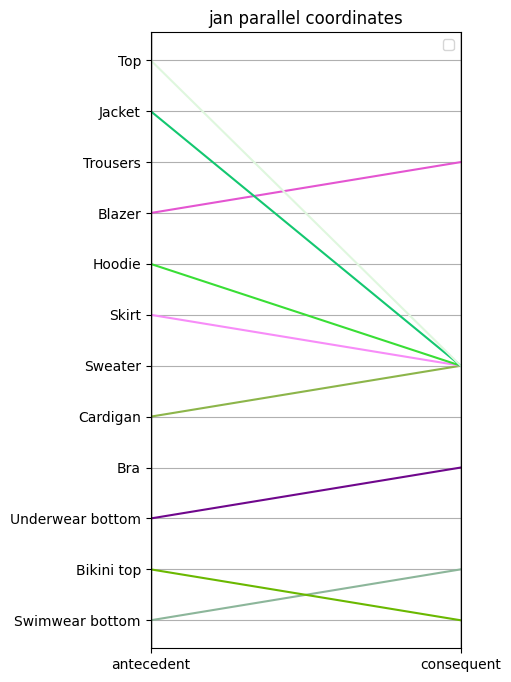

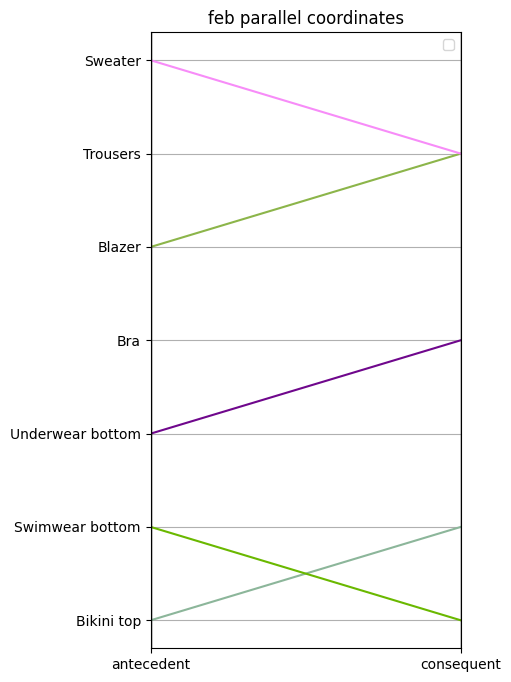

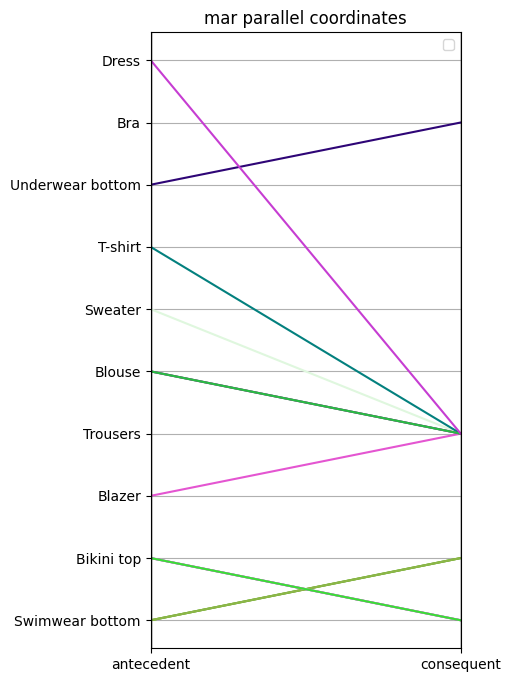

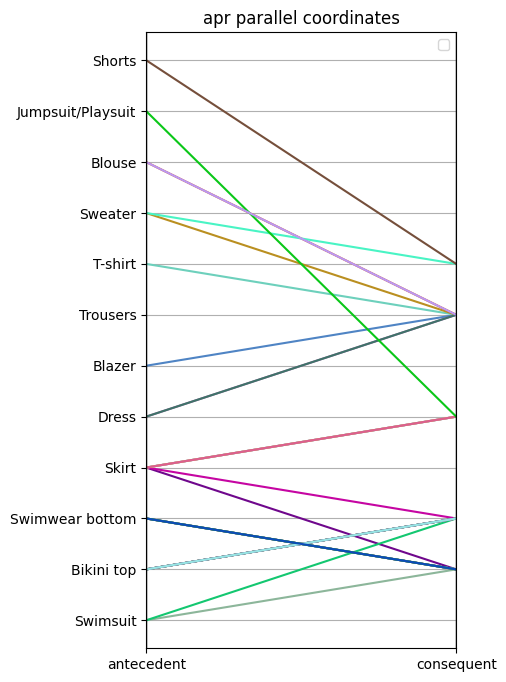

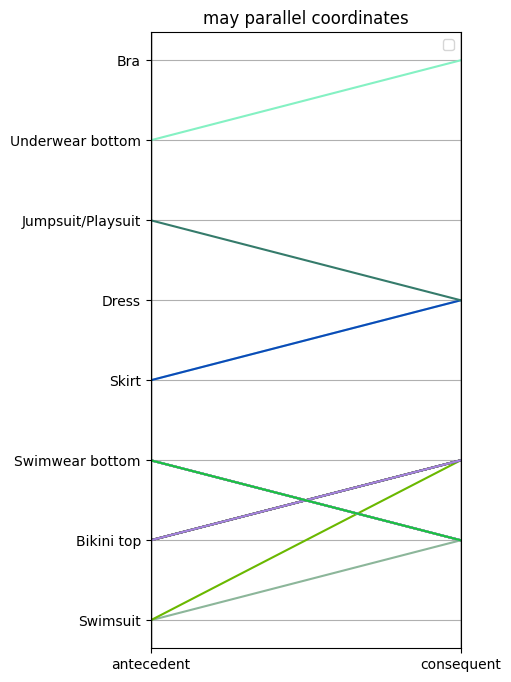

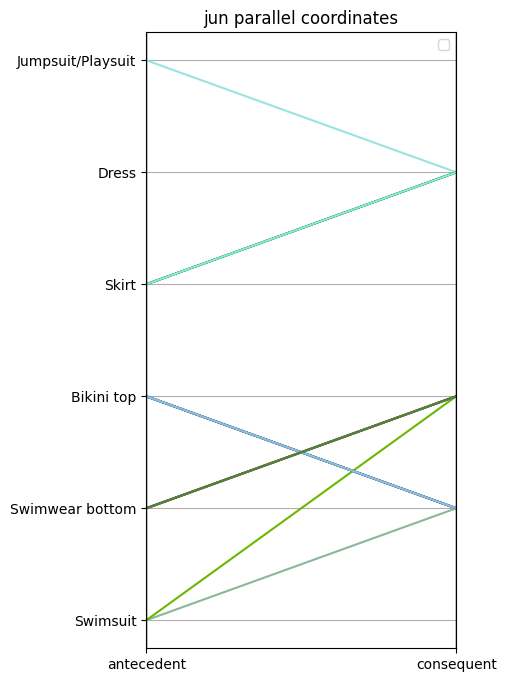

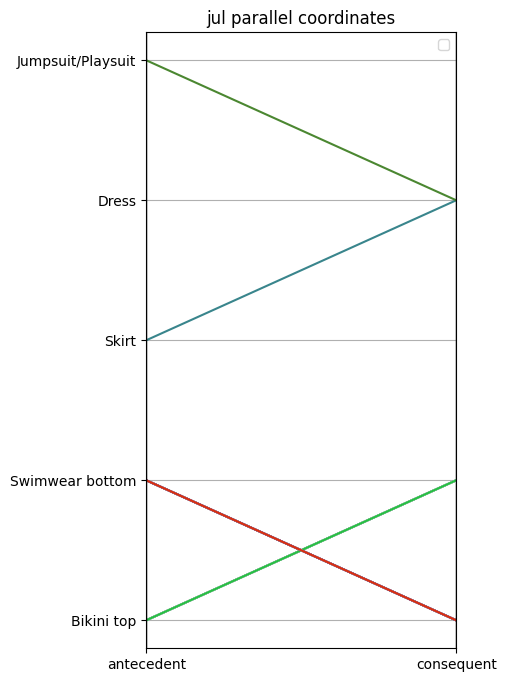

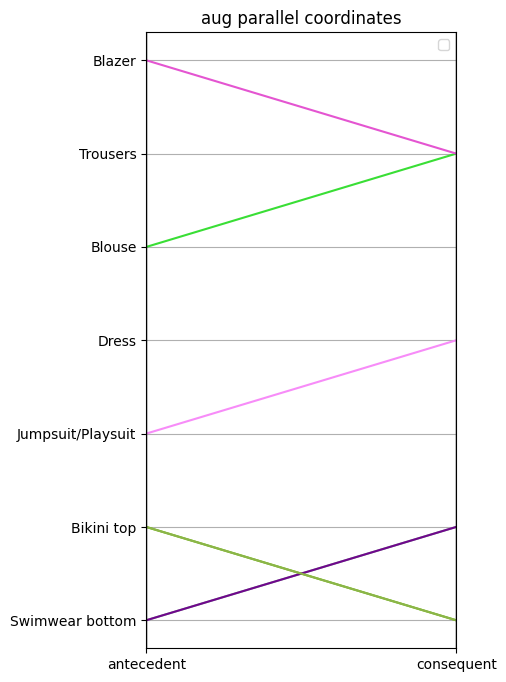

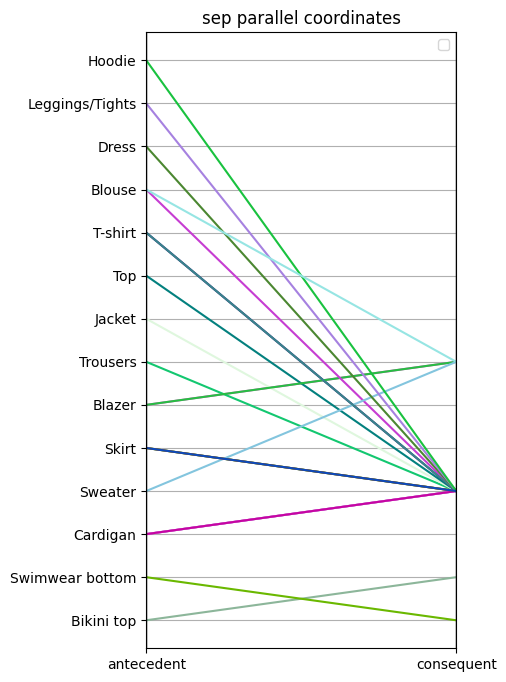

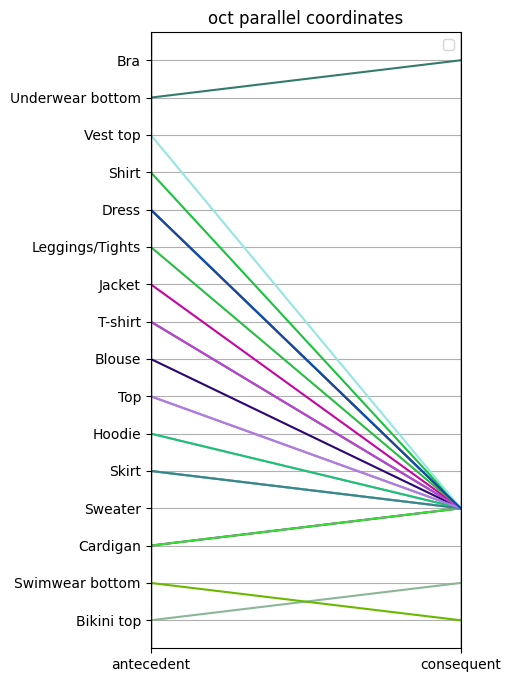

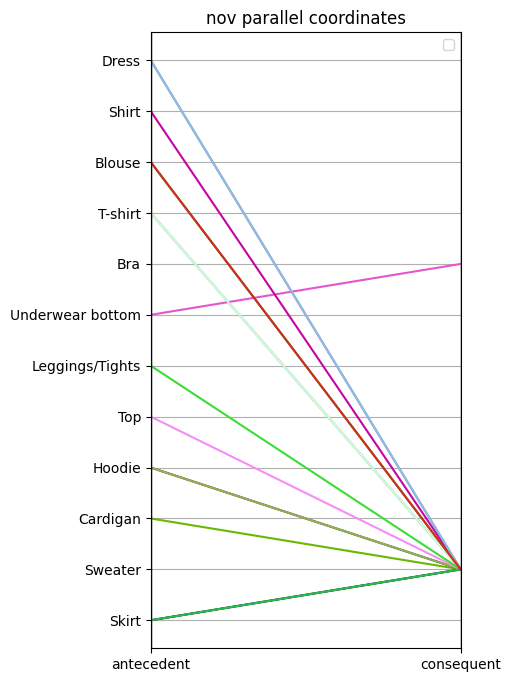

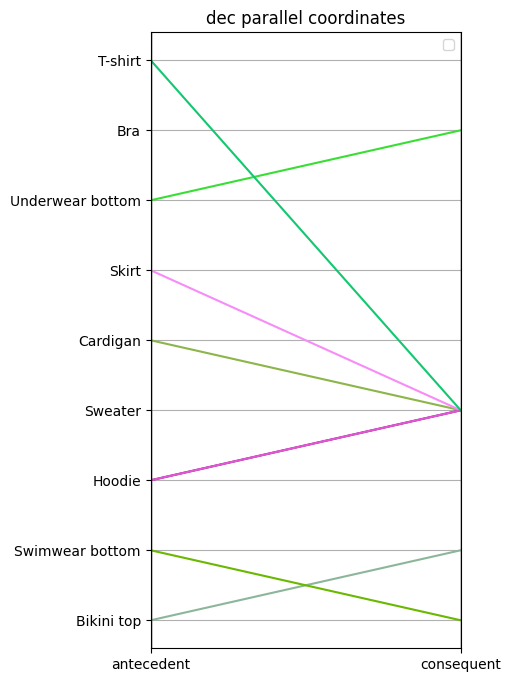

In [134]:
for month in m:
    points = rules_to_coordinates(monthly_rules[month])

    plt.figure(figsize=(4,8))
    parallel_coordinates(points, 'rule')
    plt.legend([])
    plt.grid(True)
    plt.title(month + ' parallel coordinates')
    plt.show()

In [130]:
m

1